In [215]:
!pip install xgboost

In [256]:
!pip uninstall -y numpy pmdarima
!pip install numpy --upgrade
!pip install pmdarima --no-cache-dir

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 69.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires n

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
train_ds = pd.read_csv("../content/TRAIN.csv")
test_ds = pd.read_csv("../content/TEST_FINAL.csv")

In [3]:
train = train_ds
test = test_ds

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             22265 non-null  object
 1   Store_id       22265 non-null  int64 
 2   Store_Type     22265 non-null  object
 3   Location_Type  22265 non-null  object
 4   Region_Code    22265 non-null  object
 5   Date           22265 non-null  object
 6   Holiday        22265 non-null  int64 
 7   Discount       22265 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.4+ MB


In [6]:
train = train.dropna().copy()  # 1 row — safe to drop
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

train['Store_id'] = train['Store_id'].astype(int)
train['Holiday'] = train['Holiday'].astype(int)
train['#Order'] = train['#Order'].astype(int)
test['Holiday'] = test['Holiday'].astype(int)

def add_date_parts(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Is_Weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    return df

train = add_date_parts(train)
test = add_date_parts(test)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  int64         
 2   Store_Type     188340 non-null  object        
 3   Location_Type  188340 non-null  object        
 4   Region_Code    188340 non-null  object        
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  int64         
 7   Discount       188340 non-null  object        
 8   #Order         188340 non-null  int64         
 9   Sales          188340 non-null  float64       
 10  Year           188340 non-null  int32         
 11  Month          188340 non-null  int32         
 12  Week           188340 non-null  UInt32        
 13  Day            188340 non-null  int32         
 14  DayOfWeek      188340 non-null  int32         
 15  

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             22265 non-null  object        
 1   Store_id       22265 non-null  int64         
 2   Store_Type     22265 non-null  object        
 3   Location_Type  22265 non-null  object        
 4   Region_Code    22265 non-null  object        
 5   Date           22265 non-null  datetime64[ns]
 6   Holiday        22265 non-null  int64         
 7   Discount       22265 non-null  object        
 8   Year           22265 non-null  int32         
 9   Month          22265 non-null  int32         
 10  Week           22265 non-null  UInt32        
 11  Day            22265 non-null  int32         
 12  DayOfWeek      22265 non-null  int32         
 13  Is_Weekend     22265 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), int32(4), int64(3), object(5)
memory 

In [8]:
train.rename(columns={'#Order': 'Orders'}, inplace=True)

In [9]:
train[['Date', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code',
       'Holiday', 'Discount', 'Orders', 'Sales']].sample(5)

,Date,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Orders,Sales
176007,2019-04-28,355,S2,L4,R2,0,Yes,35,23319.0
73540,2018-07-21,159,S2,L1,R3,0,No,45,33249.0
117740,2018-11-19,317,S3,L1,R1,0,No,63,34158.0
102592,2018-10-09,118,S2,L1,R4,0,No,39,27162.0
160300,2019-03-16,355,S2,L4,R2,0,No,34,22656.0


# **EDA**

## **Univariate Analysis**

#### **A. Distribution of Sales and Orders**

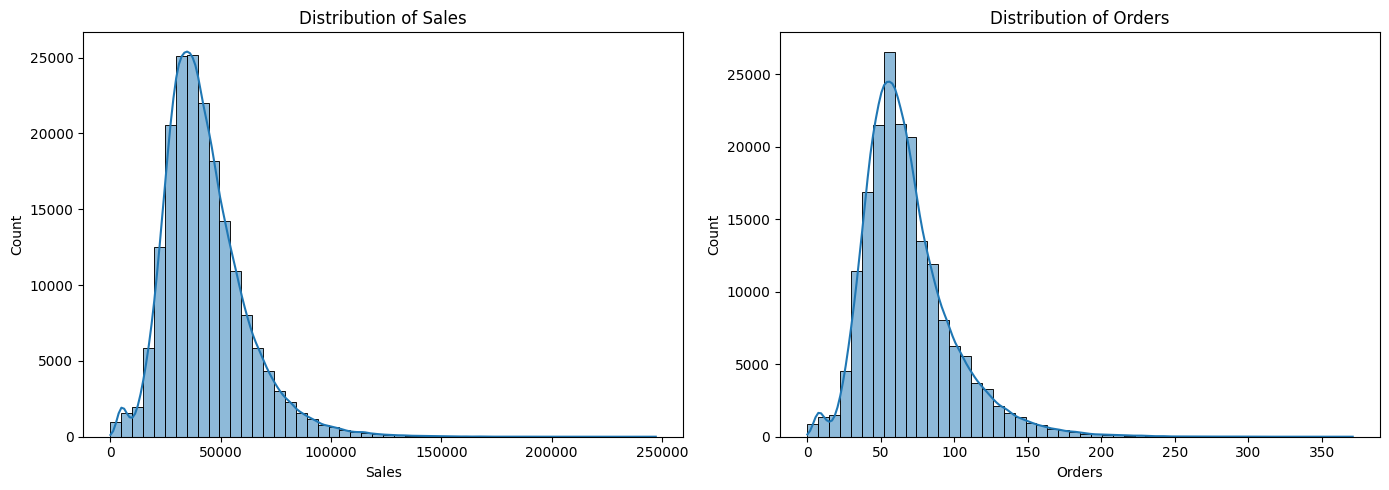

In [10]:
plt.figure(figsize=(14, 5))

# Sales
plt.subplot(1, 2, 1)
sns.histplot(train['Sales'], bins=50, kde=True)
plt.title("Distribution of Sales")

# Orders
plt.subplot(1, 2, 2)
sns.histplot(train['Orders'], bins=50, kde=True)
plt.title("Distribution of Orders")

plt.tight_layout()
plt.show()

##### **📊 Histogram Insights**


Both Sales and Orders are right-skewed (long tail to the right).

The majority of:

Sales fall between ₹20,000 – ₹60,000.

Orders mostly between 30 – 100 per day.

There's a steep drop after those values, with rare outliers reaching:

Sales > ₹200,000

Orders > 300

📌 Insight:
This skew is very common in retail. We'll need to normalize/transform these variables later when training regression models (like log transformation or scaling), especially for tree-based models or linear regression.

#### **B. Boxplots of Sales to check for outliers**

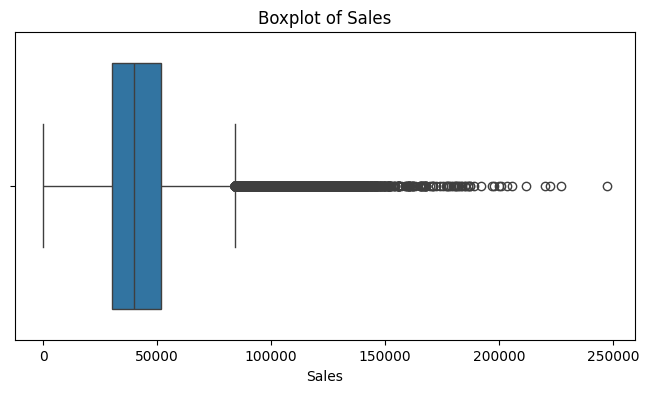

In [11]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=train['Sales'])
plt.title("Boxplot of Sales")
plt.show()

#### **Boxplot Insights**

Significant number of outliers beyond the upper whisker (typically 1.5×IQR).

The box (IQR) spans roughly ₹30k – ₹50k.

Outliers exist up to ₹2L+.

📌 Insight:

Outliers are expected in a large retail dataset — some stores or promotions will spike sales.

We won’t drop them blindly; instead:

Consider capping (winsorization) for some models

Use robust metrics (median, IQR) for dashboard summaries

In [12]:
train.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ID,188340,188340,T1000001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Store_id,188340.0,NaN,NaN,NaN,183.0,1.0,92.0,183.0,274.0,365.0,105.366308
Store_Type,188340,4,S1,88752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location_Type,188340,5,L1,85140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region_Code,188340,4,R1,63984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,188340,NaN,NaN,NaN,2018-09-15 12:00:00.000000256,2018-01-01 00:00:00,2018-05-09 18:00:00,2018-09-15 12:00:00,2019-01-22 06:00:00,2019-05-31 00:00:00,NaN
Holiday,188340.0,NaN,NaN,NaN,0.131783,0.0,0.0,0.0,0.0,1.0,0.338256
Discount,188340,2,No,104051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Orders,188340.0,NaN,NaN,NaN,68.205692,0.0,48.0,63.0,82.0,371.0,30.467415
Sales,188340.0,NaN,NaN,NaN,42784.327982,0.0,30426.0,39678.0,51909.0,247215.0,18456.708302


| Feature         | Insight                                                              |
| --------------- | -------------------------------------------------------------------- |
| `Sales`         | Mean \~ ₹42k, median \~ ₹39k, max ₹2.2L → right-skewed with outliers |
| `Orders`        | Mean \~ 68 orders/day, max = 347 → matches histogram                 |
| `Store_Type`    | 4 categories, with **S1 most common** (\~80k out of \~169k)          |
| `Location_Type` | 5 types; **L1 dominates** (\~76k)                                    |
| `Region_Code`   | Only 4 unique values → can be grouped/bar-charted                    |
| `Discount`      | Balanced but slightly more `No` → \~55% no-discount days             |
| `Holiday`       | Only \~13% of the days are holidays                                  |
| `Date Range`    | From Jan 2018 to April 2019 — around 1 year + 3 months               |


#### **C. Categorical Counts (Store Type, Location Type, Region)**

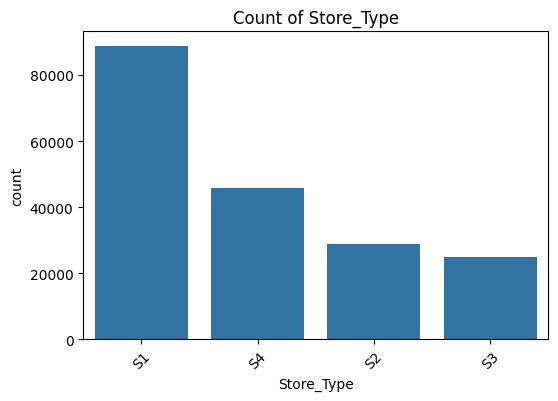

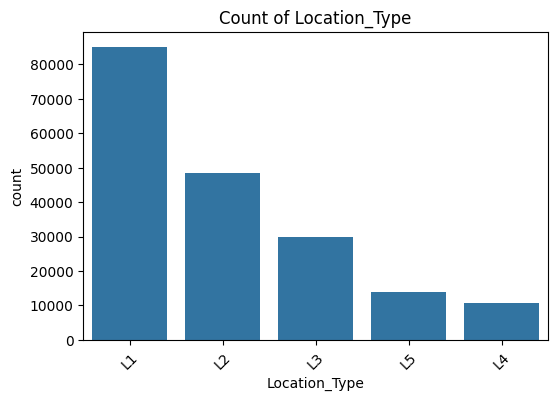

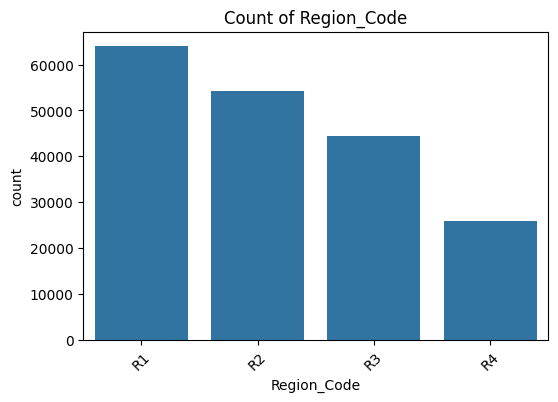

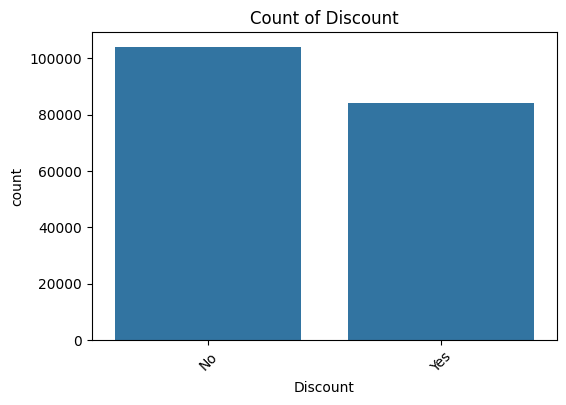

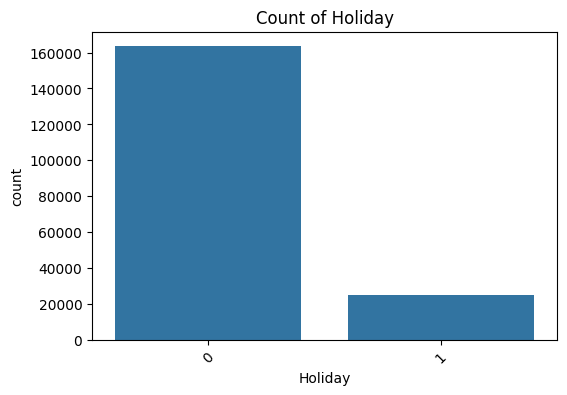

In [13]:
cat_cols = ['Store_Type', 'Location_Type', 'Region_Code', 'Discount', 'Holiday']

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()

#### **Count plot Insights**

**Count of Store_Type**

S1 stores dominate the data (80k+ rows), followed by S4, S2, and S3.

That means the model may learn patterns mostly from S1 — ensure you handle this imbalance carefully during training and evaluation.

📌 Action: Group-level analysis (sales per store type) is important to avoid bias.

**Count of Location_Type**

L1 is most common, followed by L2 → L5.

The lower frequency of L4 and L5 might mean those segments are less statistically stable in modeling.

📌 Action: You might want to merge underrepresented levels later (L4, L5) if they create modeling noise or if performance is unstable.

**Count of Region_Code**

Slightly more balanced than above — R1 > R2 > R3 > R4.

Still, R4 is less than half of R1 — might impact region-wise modeling.

📌 Insight: Regional sales modeling could still be effective due to diversity in region codes.

**Count of Discount**

Slightly more No Discount days (~93k) vs Discount (~76k).

This is good — the dataset has a healthy balance to study discount impact.

📌 Insight: This will be useful for hypothesis testing (t-test) later.

**Count of Holiday**

Only about 13% of days are holidays, rest are regular days.

We might expect higher average sales during holidays, but we'll need statistical confirmation.

📌 Action: Include holidays in all grouped time-based aggregations (sales, orders).

### **Time Series Plots**

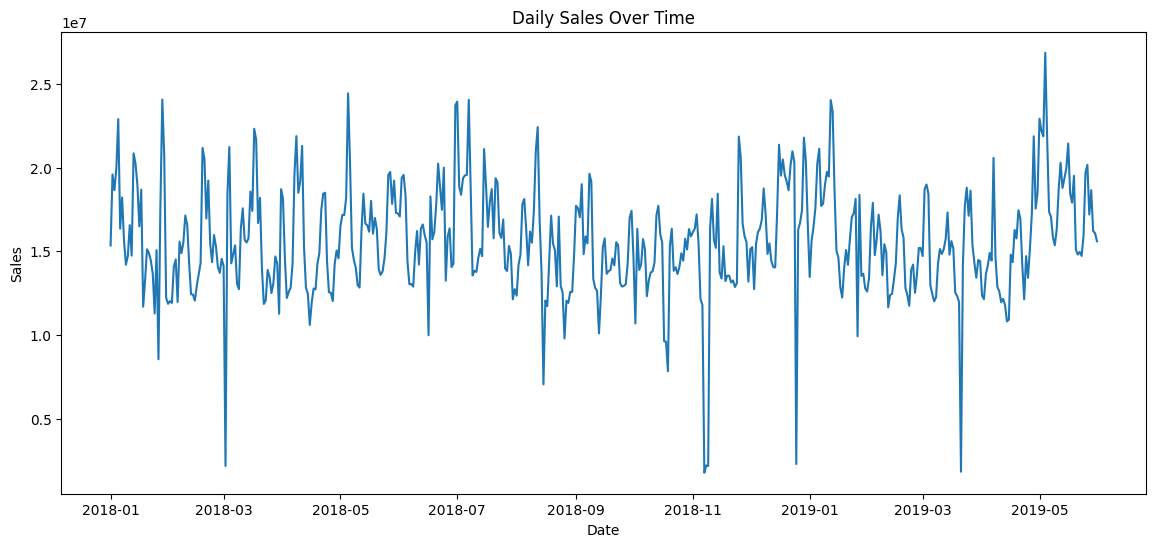

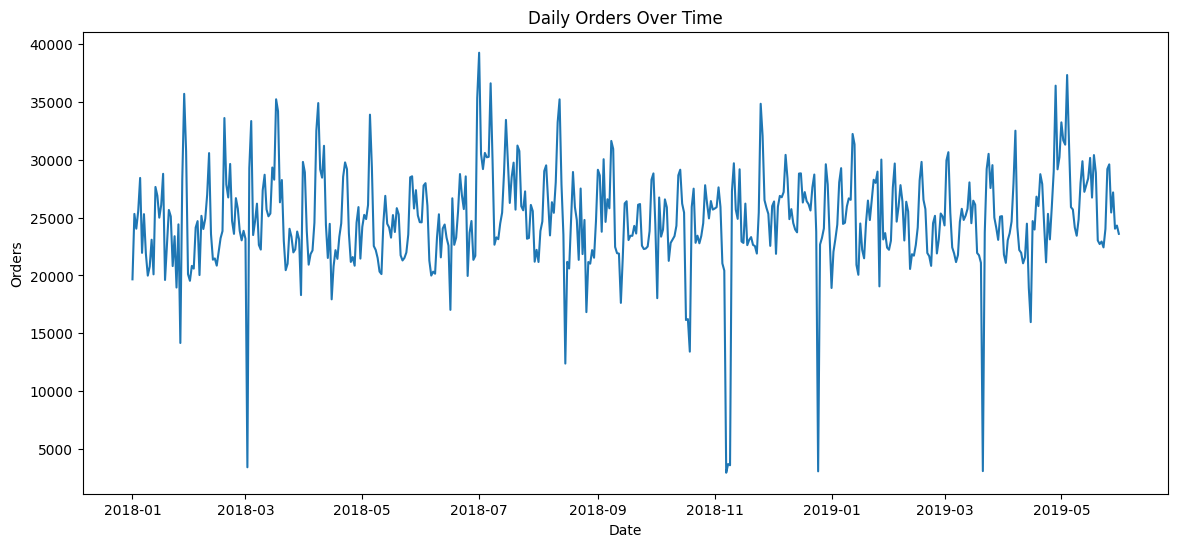

In [14]:
daily_sales = train.groupby('Date')[['Sales', 'Orders']].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales, x='Date', y='Sales')
plt.title("Daily Sales Over Time")
plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales, x='Date', y='Orders')
plt.title("Daily Orders Over Time")
plt.show()

#### **Insights**

**Daily Sales Over Time**

Y-axis: ~₹1 crore to ₹2.5 crore (1e7 = 10,000,000).

Data spans Jan 2018 to April 2019.

Appears to have weekly cycles — dips followed by quick recoveries.

Sharp drops at regular intervals — possibly Sundays, holidays, or stock outages.

Peaks seem more frequent mid-year and during December — consistent with monthly seasonality.

📌 Insights:

Seasonality is clearly present — especially in months 6–7 and 12 (as noted earlier).

Anomalies (dips or spikes) may correspond to special promo days or missing data. Worth tagging or checking.

**Daily Orders Over Time**

Same timeline and shape as sales, but with lower Y-scale (~40,000 orders max).

Strong correlation to sales — visible in simultaneous dips/spikes.

Shows slightly more stability than sales — possibly because individual order value may vary while count is steady.

📌 Insights:

Number of orders is a strong driver of sales → confirm this statistically using correlation.

Also shows periodic dips, again likely weekends or holidays.

### **Grouped Averages**

#### **A. Average Sales by Store Type and Location**

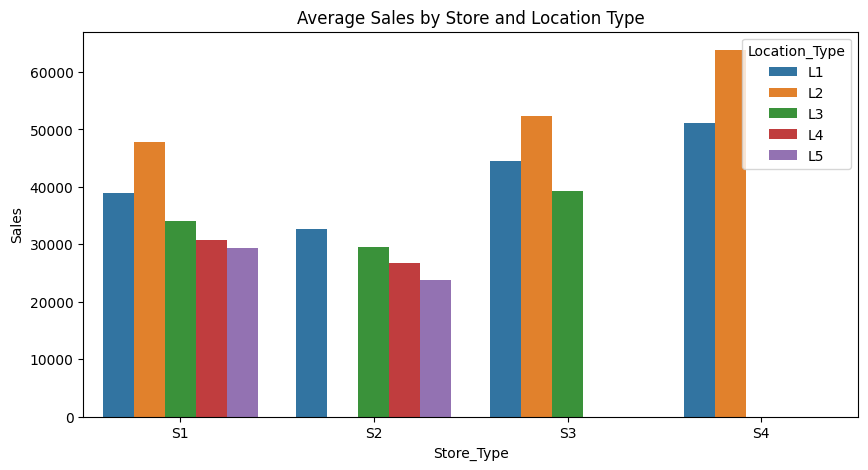

In [15]:
grouped = train.groupby(['Store_Type', 'Location_Type'])['Sales'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x='Store_Type', y='Sales', hue='Location_Type')
plt.title("Average Sales by Store and Location Type")
plt.show()

#### **Insights**

Average Sales by Store_Type and Location_Type

💡 Very informative!

S4 in L2 has the highest average sales (~₹63k+)

For each store type:

L2 consistently leads in average sales

L4 and L5 consistently trail

📌 Insights:

Store and location type interact significantly → suggests importance of interaction features.

L2 might be a high-income or high-footfall zone — this is a strong predictor.

#### **B. Sales by Month**

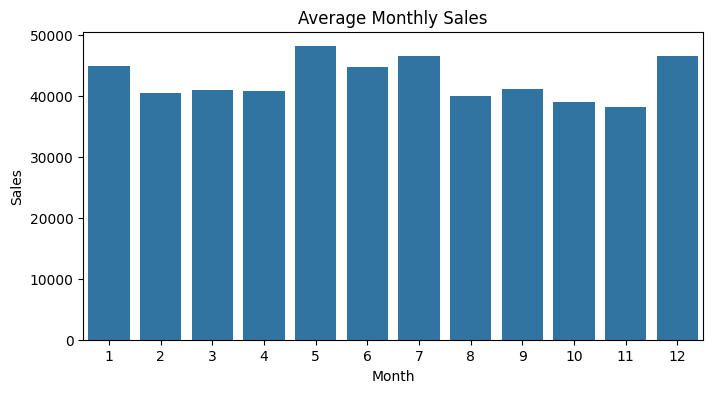

In [16]:
monthly = train.groupby('Month')['Sales'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=monthly, x='Month', y='Sales')
plt.title("Average Monthly Sales")
plt.show()


#### **Insights**

Average Monthly Sales

Sales peak in July and December (month 7 and 12)

Dip in months 8 (Aug), 10 (Oct), 11 (Nov)

📌 Insights:

There is clear seasonality in the data.

July and December likely see festive/holiday sales bumps.

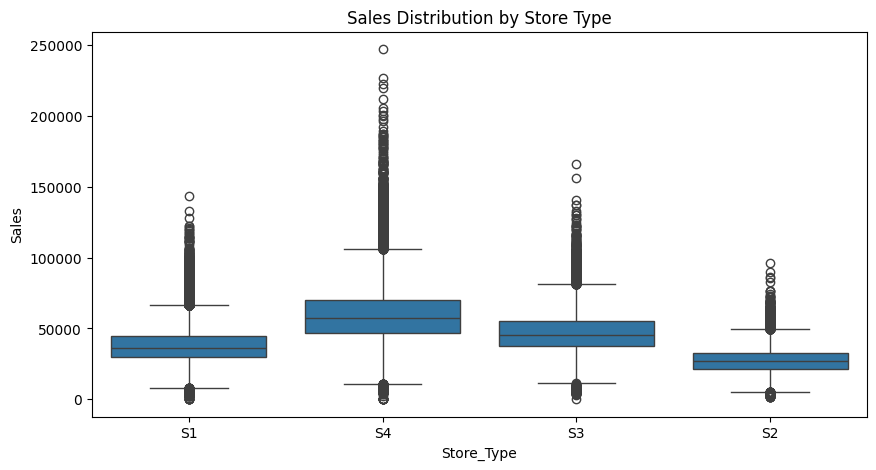

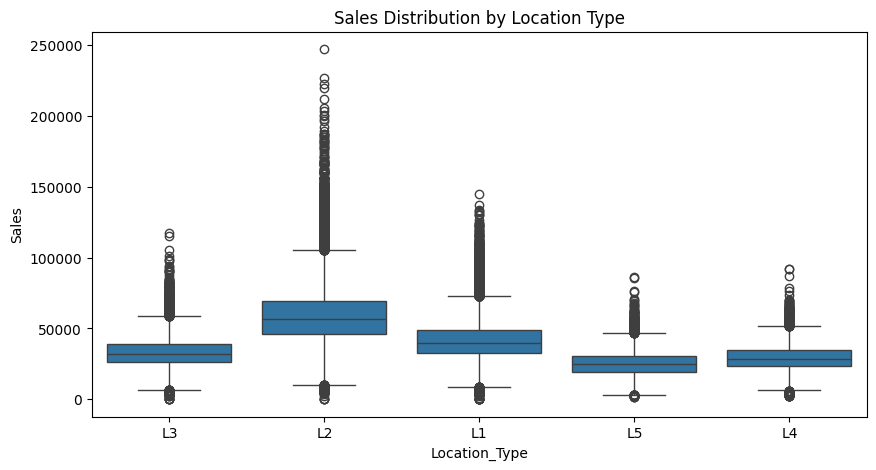

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x='Store_Type', y='Sales')
plt.title("Sales Distribution by Store Type")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x='Location_Type', y='Sales')
plt.title("Sales Distribution by Location Type")
plt.show()

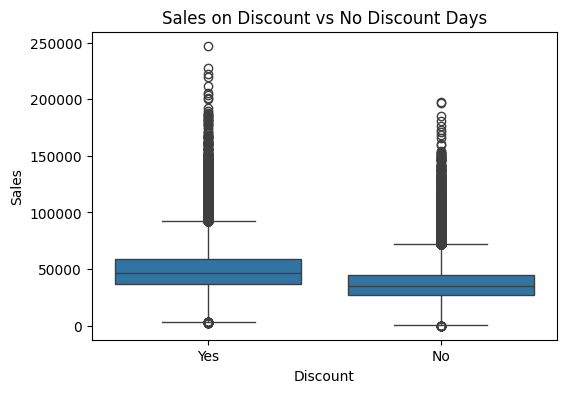

In [18]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=train, x='Discount', y='Sales')
plt.title("Sales on Discount vs No Discount Days")
plt.show()

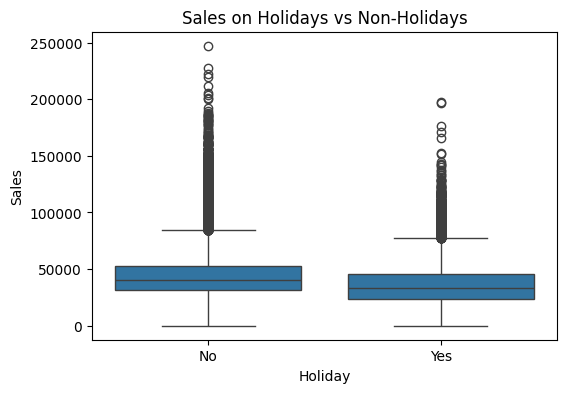

In [19]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=train, x='Holiday', y='Sales')
plt.title("Sales on Holidays vs Non-Holidays")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

#### **Insights**

**Sales Distribution by Store Type**

What we see:

S4 stores have the highest median and widest spread — these seem like premium or high-traffic stores.

S2 stores show the lowest median sales and the most compact distribution.

All store types have significant outliers — expected due to promo days or seasonal surges.

📌 Takeaway:

Store_Type is strongly associated with sales.

Include it in modeling — and you may also want to create dummy variables (OHE) or even consider a model per store type later.


**Sales by Location Type**

Observations:

L2 leads significantly in both median and upper quartile.

L3, L1 show similar ranges (but L1 has more high outliers).

L4 and L5 have low and tight distributions.

📌 Takeaway:

Another strong predictor.

Consider grouping L4 & L5 if modeling suffers due to class imbalance (they’re low in count too).


**Sales on Discount vs No Discount Days**

What’s clear:

Sales on Discount days are consistently higher.

Median sales, IQR, and even high outliers are all greater under discounts.

📌 Takeaway:

Visual pattern suggests significant difference → we’ll statistically validate this via a t-test.

**Sales on Holiday vs Non-Holiday Days**

What we see:

Slightly higher spread and upper outliers on holidays.

But the median seems only marginally different.

📌 Takeaway:

Visually, holiday impact is less pronounced than discounts.

Still worth testing — we’ll confirm statistically if it’s significant.



### **Weekly & Day-of-Week Analysis**

#### **Average Sales by Day of Week**

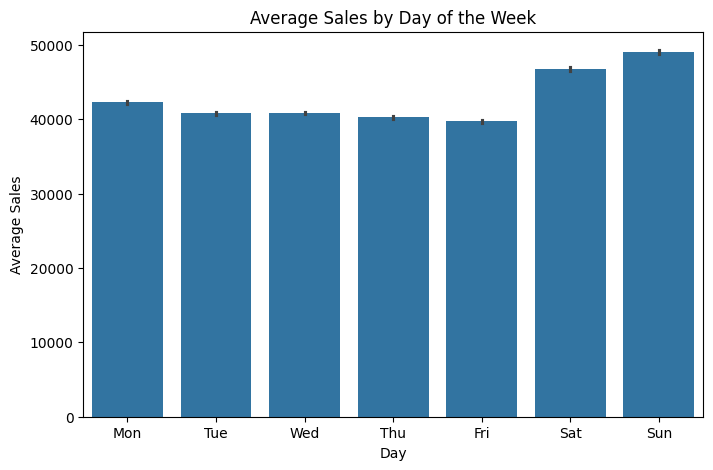

In [20]:
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
train['DayName'] = train['DayOfWeek'].map(day_map)
plt.figure(figsize=(8, 5))
sns.barplot(data=train, x='DayName', y='Sales', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Average Sales by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Average Sales")
plt.show()


#### **Average Sales by Day of the Week**

Sunday and Saturday have the highest average sales (~₹49K and ₹46K).

Friday is the lowest — ~₹39K.

Monday is slightly better than mid-week days.

📌 Insight:

Clear weekend uplift in sales — this is common in B2C retail.

Use DayOfWeek or Is_Weekend as a feature in your model.

#### **Average Sales by Week Number**

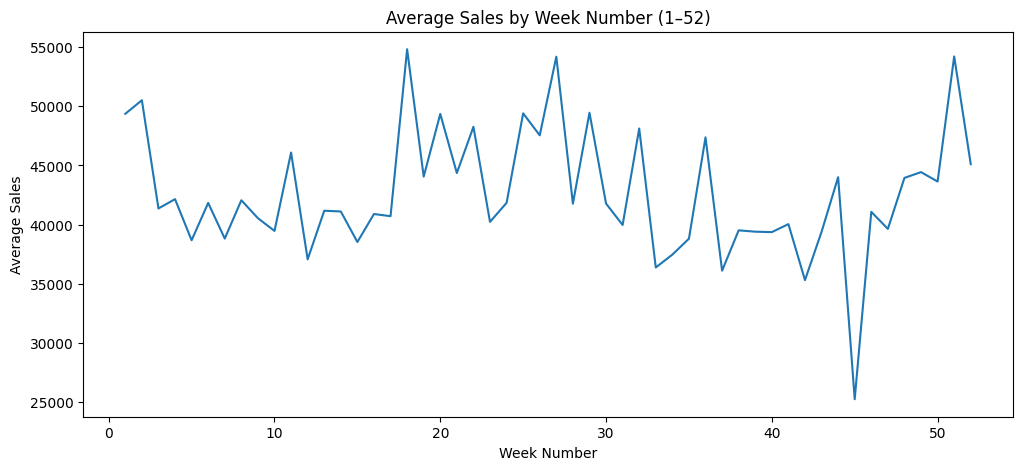

In [21]:
train['Week'] = train['Week'].astype(int)

weekly_sales = train.groupby('Week')['Sales'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=weekly_sales, x='Week', y='Sales')
plt.title("Average Sales by Week Number (1–52)")
plt.xlabel("Week Number")
plt.ylabel("Average Sales")
plt.show()

#### **Average Sales by Week Number**

Spikes in Week 27 and Week 52 (mid-year and year-end).

Trough in Week 46 (~₹26K) — could correspond to a low-demand period.

Variability shows possible impact of promotions or events.

📌 Insight:

There's a strong seasonal signal in certain weeks.

Feature like Week or Week_Sin/Cos (cyclical encoding) may help.

### **Heatmaps (Calendar-style)**

#### **Heatmap: Sales by Month vs Day of Week**

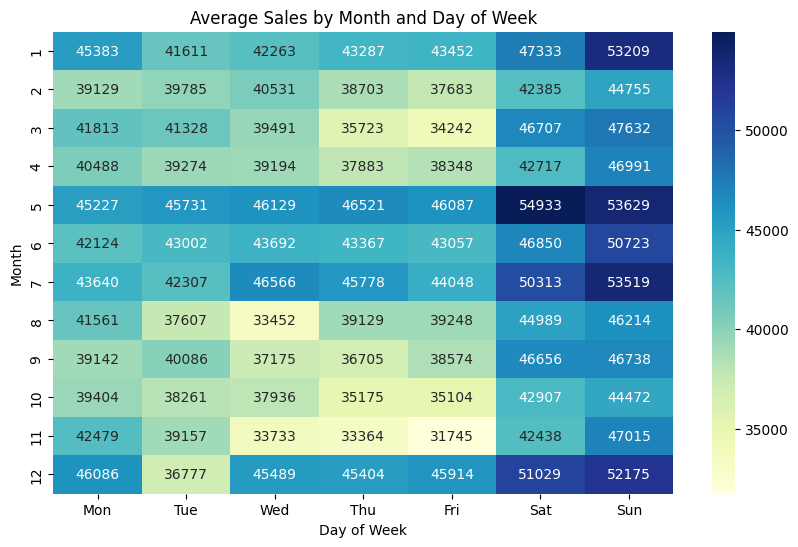

In [22]:
pivot = train.pivot_table(index='Month', columns='DayName', values='Sales', aggfunc='mean')

# Reorder columns
pivot = pivot[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Average Sales by Month and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Month")
plt.show()

#### **Heatmap: Sales by Month and Day of Week**

Weekends (Sat, Sun) are higher across almost all months.

May, July, and December show strong performance across all days.

Worst-performing month is August, especially mid-week (Tue–Thu).

📌 Insight:

The combination of temporal features + day-of-week gives excellent predictive strength.

Useful for both modeling and Tableau storytelling.

#### **Heatmap: Sales by Month vs Store Type**

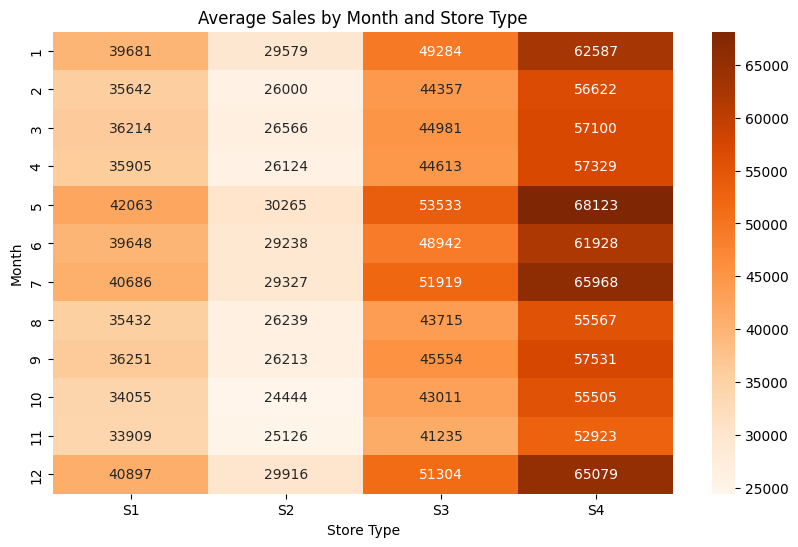

In [23]:
pivot2 = train.pivot_table(index='Month', columns='Store_Type', values='Sales', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot2, cmap="Oranges", annot=True, fmt=".0f")
plt.title("Average Sales by Month and Store Type")
plt.xlabel("Store Type")
plt.ylabel("Month")
plt.show()


#### **Heatmap: Sales by Month vs Store Type**

S4 consistently dominates across all months (₹65K+ avg).

S3 peaks in July and December, echoing earlier monthly patterns.

S2 lags behind across all months.

📌 Insight:

Confirms earlier boxplot findings.

Seasonal impact is store-type-dependent → interaction effect is real and useful!

### **Summary**

| Feature        | Action                                                      |
| -------------- | ----------------------------------------------------------- |
| Store\_Type    | Use in modeling; S1 dominant                                |
| Location\_Type | Use as categorical feature; L2 most lucrative               |
| Region\_Code   | Moderate balance; may help region-specific strategies       |
| Discount       | Suitable for hypothesis testing                             |
| Holiday        | Rare, but likely impactful                                  |
| Interactions   | **Store\_Type × Location\_Type** should be modeled          |
| Seasonality    | Time series modeling must include **Month**, **Week**, etc. |


## **Hypothesis Testing - Assess which features are strong contributors statistically**

### **Hypothesis 1: Do Discounts Lead to Higher Sales?**
Formulation:

**Null (H₀)** : Mean sales on discount days = mean sales on non-discount days

**Alternate (H₁)** : Mean sales on discount days ≠ mean sales on non-discount days

In [24]:
sales_discount = train[train['Discount'] == 'Yes']['Sales']
sales_no_discount = train[train['Discount'] == 'No']['Sales']

t_stat, p_val = ttest_ind(sales_discount, sales_no_discount, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")
print("Avg Sales on Discount Days:", round(sales_discount.mean(), 2))
print("Avg Sales on Non-Discount Days:", round(sales_no_discount.mean(), 2))


T-statistic: 145.9295
P-value: 0.0000
Avg Sales on Discount Days: 49426.5
Avg Sales on Non-Discount Days: 37403.68


#### **Interpretation:**

Since p-value < 0.05, we reject the null hypothesis.

There is a statistically significant difference in sales between discount and non-discount days.

The average sales are ~₹12,000 higher on discount days.

**This confirms what we observed visually — discounts significantly boost sales.**

### **Hypothesis Test 2: Holiday vs Non-Holiday Days**

**Null (H₀)** : Sales on holidays = Sales on non-holidays

**Alternate (H₁)** : Sales on holidays ≠ Sales on non-holidays

In [25]:
sales_holiday = train[train['Holiday'] == 1]['Sales']
sales_nonholiday = train[train['Holiday'] == 0]['Sales']

t_stat_holiday, p_val_holiday = ttest_ind(sales_holiday, sales_nonholiday, equal_var=False)

print(f"T-statistic: {t_stat_holiday:.4f}")
print(f"P-value: {p_val_holiday:.4f}")
print("Avg Sales on Holidays:", round(sales_holiday.mean(), 2))
print("Avg Sales on Non-Holidays:", round(sales_nonholiday.mean(), 2))

T-statistic: -66.1758
P-value: 0.0000
Avg Sales on Holidays: 35451.88
Avg Sales on Non-Holidays: 43897.29


#### **Interpretation:**

Since p-value < 0.05, we reject the null hypothesis.

There is a statistically significant difference in sales between holiday and non-holiday days.

However, unlike common assumptions, sales are significantly lower on holidays in this dataset.

**Possible Explanations:**

Stores might be closed or partially operating on holidays.

Customers may not shop during holidays in this context (e.g., non-essential retail).

Need domain context (like store policy or product type) to explain.

*Can be inferred better in tableau*

### **Hypothesis Test 3: Do Sales Differ by Store Type?**

We now check if sales differ significantly across S1, S2, S3, S4 using ANOVA.

**H₀** : All store types have the same average sales

**H₁** : At least one store type differs significantly

In [26]:
groups = [group['Sales'].values for name, group in train.groupby('Store_Type')]
f_stat, p_val = f_oneway(*groups)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4f}")
print(train.groupby('Store_Type')['Sales'].mean())

F-statistic: 35123.6441
P-value: 0.0000
Store_Type
S1    37676.511694
S2    27530.828222
S3    47063.068209
S4    59945.685926
Name: Sales, dtype: float64


#### **Interpretation:**

Since p-value < 0.05, we reject the null hypothesis.

There is a statistically significant difference in sales across store types.

S4 stores significantly outperform others, followed by S3.

**This supports what we saw visually — store type is a strong predictor for modeling.**

*We can use this in Tableau to segment sales and forecast potential.*

### **Hypothesis Test 4: Do Sales Vary Across Regions?**

Region codes: R1, R2, R3, R4 — categorical, but with no natural ordering.

Let's test this with ANOVA first, and if the data is not normal, we'll try Kruskal-Wallis.

**H₀** : All regions have the same average sales

**H₁** : At least one region has different sales

In [27]:
region_groups = [group['Sales'].values for name, group in train.groupby('Region_Code')]
f_stat_reg, p_val_reg = f_oneway(*region_groups)

print(f"F-statistic: {f_stat_reg:.4f}")
print(f"P-value: {p_val_reg:.4f}")
print(train.groupby('Region_Code')['Sales'].mean())

F-statistic: 1682.4255
P-value: 0.0000
Region_Code
R1    46765.488405
R2    40054.847344
R3    42144.517063
R4    39743.434249
Name: Sales, dtype: float64


#### **Interpretation:**

Since p < 0.05, we reject the null hypothesis.

There is a significant difference in sales across regions.

R1 outperforms all other regions significantly.

**Region is another important categorical predictor to include in modeling and dashboard slicing.**

### **Correlation Between Orders and Sales**

**H₀** : No correlation between number of orders and total sales

**H₁** : There is a significant correlation

We'll test both:

**Pearson:** for linear correlation (sensitive to outliers)

**Spearman:** for monotonic relationship (rank-based, robust to outliers)

In [28]:
# Pearson correlation
pearson_corr, pearson_p = pearsonr(train['Orders'], train['Sales'])
print(f"Pearson Correlation: {pearson_corr:.4f}, P-value: {pearson_p:.4f}")

# Spearman correlation
spearman_corr, spearman_p = spearmanr(train['Orders'], train['Sales'])
print(f"Spearman Correlation: {spearman_corr:.4f}, P-value: {spearman_p:.4f}")

Pearson Correlation: 0.9416, P-value: 0.0000
Spearman Correlation: 0.9377, P-value: 0.0000


#### **Interpretation:**

Both Pearson and Spearman correlations are > 0.93 → this is a very strong positive relationship.

Since p < 0.05, the correlations are statistically significant.

**This confirms a strong, monotonic and linear relationship:**

**As the number of orders increases, total sales increase consistently and strongly.**

We can:

Use Orders as a direct feature

Consider it for creating derived features like Sales per Order, etc.

### **Final Summary: Hypothesis Testing Block**

| Hypothesis         | Result               | Insight                           |
| ------------------ | -------------------- | --------------------------------- |
| 💸 Discount impact | ✅ Significant        | Sales **↑ ₹12k** on discount days |
| 🎉 Holiday impact  | ✅ Significant        | Sales **↓ ₹8k** on holidays       |
| 🏬 Store Type      | ✅ Significant        | S4 > S3 > S1 > S2                 |
| 🌍 Region Code     | ✅ Significant        | R1 > R3 > R2 > R4                 |
| 📦 Orders vs Sales | ✅ Strong correlation | r ≈ 0.94                          |


# **Model Preparation**

## **Drop Columns**

In [29]:
test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Year,Month,Week,Day,DayOfWeek,Is_Weekend
0,T1188341,171,S4,L2,R3,2019-06-01,0,No,2019,6,22,1,5,1
1,T1188342,172,S1,L1,R1,2019-06-01,0,No,2019,6,22,1,5,1
2,T1188343,173,S4,L2,R1,2019-06-01,0,No,2019,6,22,1,5,1
3,T1188344,174,S1,L1,R4,2019-06-01,0,No,2019,6,22,1,5,1
4,T1188345,170,S1,L1,R2,2019-06-01,0,No,2019,6,22,1,5,1


In [30]:
cols_to_drop = ['ID', 'Date']
train_model = train.drop(columns=cols_to_drop)
train_model = train_model.drop(columns=['DayName'])
test_model = test.drop(columns=cols_to_drop)

In [31]:
train_model.columns

Index(['Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Holiday',
       'Discount', 'Orders', 'Sales', 'Year', 'Month', 'Week', 'Day',
       'DayOfWeek', 'Is_Weekend'],
      dtype='object')

## **Encode Categorical Variables**

Categorical columns:

Store_Type

Location_Type

Region_Code

Discount (Yes/No)

Let us use One-Hot Encoding for simplicity (since most have low cardinality).

In [32]:
cat_cols = ['Store_Type', 'Location_Type', 'Region_Code', 'Discount']
train_model = pd.get_dummies(train_model, columns=cat_cols, drop_first=True)
test_model = pd.get_dummies(test_model, columns=cat_cols, drop_first=True)
train_model, test_model = train_model.align(test_model, join='left', axis=1, fill_value=0)

## **Train-Test Split (Time Based)**

We'll simulate a real forecasting scenario by splitting by date — not random split.

Let's take:

Train: All data before 2019

Validation: Jan–April 2019

In [33]:
train['Date'] = pd.to_datetime(train['Date'])
train_cutoff = pd.to_datetime('2019-01-01')
mask_train = train['Date'] < train_cutoff
mask_val = train['Date'] >= train_cutoff

X_train = train_model.loc[mask_train].drop(columns='Sales')
y_train = train_model.loc[mask_train]['Sales']
X_val = train_model.loc[mask_val].drop(columns='Sales')
y_val = train_model.loc[mask_val]['Sales']

In [34]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (133225, 20)
y_train: (133225,)
X_val: (55115, 20)
y_val: (55115,)


# **Model Training & Evaluation**

## **Baseline Model — Linear Regression**

Let us
* Train the model
* Predict on validation set

Evaluate using:

* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* MAPE (Mean Absolute Percentage Error)

In [35]:
X_train.head()

,Store_id,Holiday,Orders,Year,Month,Week,Day,DayOfWeek,Is_Weekend,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4,Discount_Yes
0,1,1,9,2018,1,1,1,0,0,False,False,False,False,True,False,False,False,False,False,True
1,253,1,60,2018,1,1,1,0,0,False,False,True,True,False,False,False,False,False,False,True
2,252,1,42,2018,1,1,1,0,0,False,True,False,True,False,False,False,False,False,False,True
3,251,1,23,2018,1,1,1,0,0,True,False,False,False,True,False,False,False,False,False,True
4,250,1,62,2018,1,1,1,0,0,True,False,False,False,True,False,False,False,False,True,True


In [36]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# mape = mean_absolute_percentage_error(y_val, y_pred)
non_zero_mask = y_val != 0
mape = np.mean(np.abs((y_val[non_zero_mask] - y_pred[non_zero_mask]) / y_val[non_zero_mask])) * 100

print(f"Linear Regression Performance:")
print(f"MAE:  ₹{mae:.2f}")
print(f"RMSE: ₹{rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

Linear Regression Performance:
MAE:  ₹4116.87
RMSE: ₹5535.37
MAPE: 9.96%


#### **Plot Predictions vs Actual**

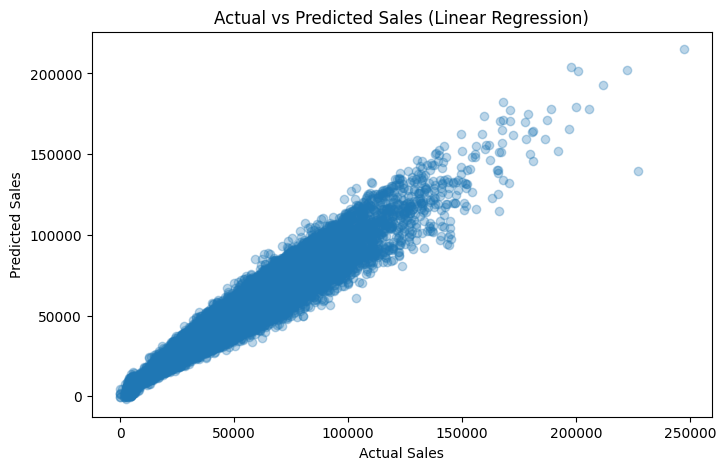

In [37]:
plt.figure(figsize=(8,5))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (Linear Regression)")
plt.show()

#### **Save Predictions for Tableau**

In [38]:
val_results = X_val.copy()
val_results['Actual_Sales'] = y_val
val_results['Predicted_Sales'] = y_pred
val_results.to_csv('../content/predictions_linear.csv', index=False)

## **Model 2 — XGBoost Regressor**

We’ll now:

* Train a more powerful model: XGBoost
* Predict and evaluate using same metrics: MAE, RMSE, MAPE
* Optionally export predictions for Tableau

In [39]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

In [40]:
mae = mean_absolute_error(y_val, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
non_zero_mask = y_val != 0
mape = np.mean(np.abs((y_val[non_zero_mask] - y_pred[non_zero_mask]) / y_val[non_zero_mask])) * 100

print("XGBoost Model Performance:")
print(f"MAE: ₹{mae:.2f}")
print(f"RMSE: ₹{rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

XGBoost Model Performance:
MAE: ₹2435.30
RMSE: ₹3699.50
MAPE: 9.96%


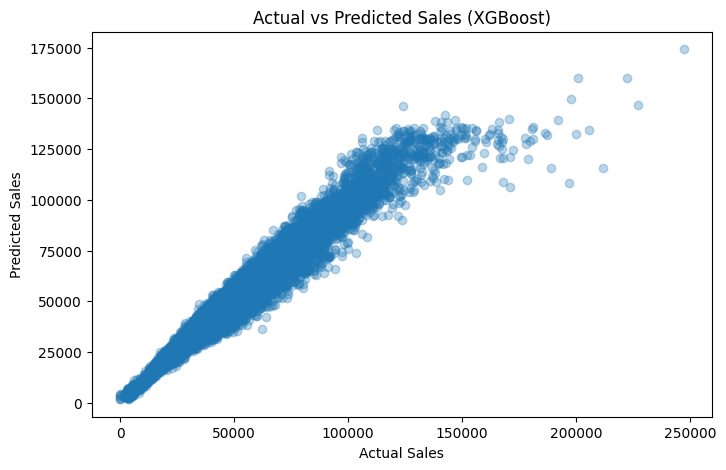

In [41]:
plt.figure(figsize=(8,5))
plt.scatter(y_val, y_pred_xgb, alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (XGBoost)")
plt.show()

In [42]:
val_results = X_val.copy()
val_results['Actual_Sales'] = y_val
val_results['Predicted_Sales'] = y_pred_xgb

val_results.to_csv('../content/predictions_xgboost.csv', index=False)

In [43]:
print(f"Minimum y_val: {np.min(y_val)}")
print(f"Count of zero y_val: {(y_val == 0).sum()}")

Minimum y_val: 0.0
Count of zero y_val: 6


### **Model Performance Summary**

| Metric   | Linear Regression | XGBoost   |
| -------- | ----------------- | --------- |
| **MAE**  | ₹4116.87          | ₹2435.30  |
| **RMSE** | ₹5535.37          | ₹3699.50  |
| **MAPE** | **9.96%**         | **9.96%** |


#### **Interpretation:**

XGBoost outperforms Linear Regression in both MAE and RMSE, meaning it gives better predictions overall.

MAPE is the same (~9.96%) for both, likely because it's averaged over many values — though the variance is better handled by XGBoost.

### **Predict on Test Data and Prepare Submission**

In [44]:
test.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek',
       'Is_Weekend'],
      dtype='object')

In [45]:
test_model = test_model.drop(columns=["Sales"])

In [46]:
test_predictions = xgb_model.predict(test_model)
submission = pd.DataFrame({
    'ID': test['ID'],
    'Sales_Predicted': test_predictions
})

submission.to_csv("../content/sales_predictions.csv", index=False)
submission.head()

,ID,Sales_Predicted
0,T1188341,6040.433105
1,T1188342,6611.072754
2,T1188343,6124.573242
3,T1188344,7243.184082
4,T1188345,6869.363770


## **Time-series Forecasting**

### **Aggregate Time Series Data**
We'll resample daily sales to weekly totals to reduce noise and make trends more visible.

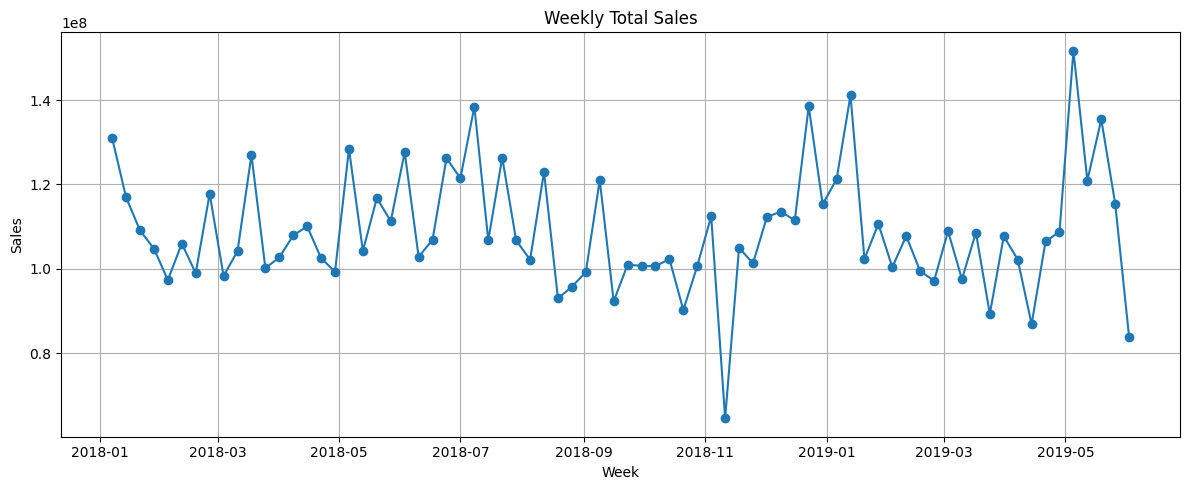

In [47]:
train['Date'] = pd.to_datetime(train['Date'])

weekly_sales = (
    train.groupby(pd.Grouper(key='Date', freq='W'))['Sales']
    .sum()
    .reset_index()
    .rename(columns={'Sales': 'Weekly_Sales'})
)

weekly_sales.set_index('Date', inplace=True)

plt.figure(figsize=(12, 5))
plt.plot(weekly_sales.index, weekly_sales['Weekly_Sales'], marker='o')
plt.title('Weekly Total Sales')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

#### **The weekly sales plot shows a clear seasonal pattern with spikes — especially toward the end of the year and early summer, which suggests potential seasonality and trend, perfect for SARIMA or Prophet later.**

### **ARIMA Modeling (Baseline)**

We'll start with ARIMA, which works on stationary time series (i.e., constant mean and variance over time). Let’s proceed step-by-step:

#### **Check Stationarity (ADF Test)**

In [48]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(weekly_sales['Weekly_Sales'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"P-value: {result[1]:.4f}")

ADF Statistic: -2.7450
P-value: 0.0666


#### **The series is not stationary (ADF p-value = 0.0666 > 0.05), so we must difference the series before applying ARIMA.**

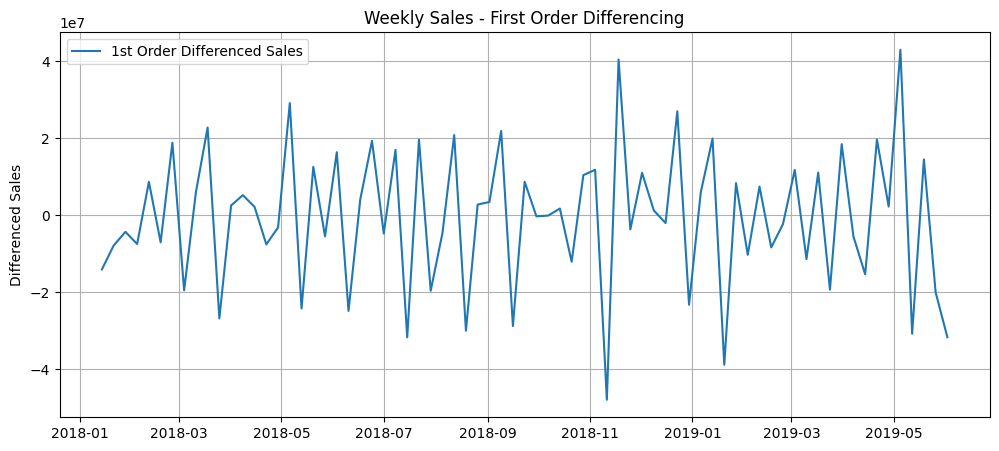

In [49]:
# First-order differencing
weekly_sales['Weekly_Sales_Diff'] = weekly_sales['Weekly_Sales'].diff()

# Drop NA and plot
plt.figure(figsize=(12,5))
plt.plot(weekly_sales['Weekly_Sales_Diff'].dropna(), label='1st Order Differenced Sales')
plt.title("Weekly Sales - First Order Differencing")
plt.ylabel("Differenced Sales")
plt.grid(True)
plt.legend()
plt.show()


In [50]:
# ADF test after differencing
result_diff = adfuller(weekly_sales['Weekly_Sales_Diff'].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"P-value (Differenced): {result_diff[1]:.4f}")

ADF Statistic (Differenced): -5.1152
P-value (Differenced): 0.0000


#### **ADF p-value after differencing = 0.0000 < 0.05, so the differenced series is stationary → We can now proceed to ARIMA modeling with d=1**

### **Fit ARIMA Model (Using auto_arima)**

Let’s now let auto_arima figure out the best (p, d, q) parameters.

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(weekly_sales['Weekly_Sales'], order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                   74
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1312.328
Date:                Sat, 16 Aug 2025   AIC                           2630.656
Time:                        20:42:50   BIC                           2637.527
Sample:                    01-07-2018   HQIC                          2633.394
                         - 06-02-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1402      0.096      1.455      0.146      -0.049       0.329
ma.L1         -0.7500      0.101     -7.415      0.000      -0.948      -0.552
sigma2      2.214e+14        nan        nan        n

### **Forecast with ARIMA**

Let’s forecast for the next 12 weeks and plot it:

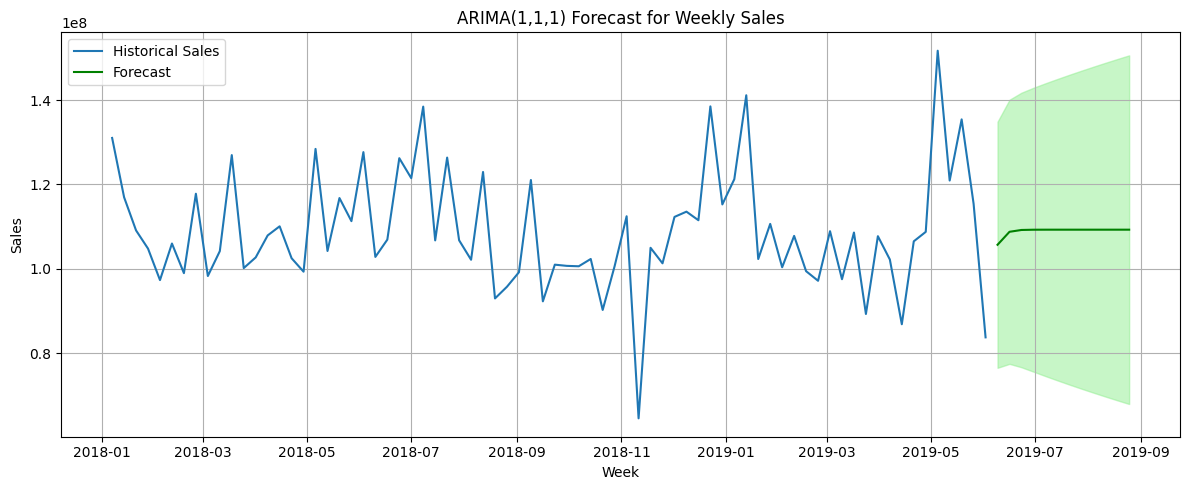

In [53]:
# Forecast next 12 weeks
forecast = model_fit.get_forecast(steps=12)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Dates for forecast
last_date = weekly_sales.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=12, freq='W')


# Plot
plt.figure(figsize=(12, 5))
plt.plot(weekly_sales.index, weekly_sales['Weekly_Sales'], label='Historical Sales')
plt.plot(future_dates, forecast_values, label='Forecast', color='green')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgreen', alpha=0.5)
plt.title("ARIMA(1,1,1) Forecast for Weekly Sales")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### **Interpretation of Results**
📉 Forecast Plot:

* The green line represents the point forecast for the next 12 weeks.
* The light green shaded area is the 95% confidence interval.
* The forecast seems stable (flat) — a common behavior with ARIMA when there's no strong trend or seasonality explicitly modeled.

#### **Model Summary Highlights:**

* AR coefficient (p=1): 0.1402, not significant (p=0.146).
* MA coefficient (q=1): -0.75, significant (p < 0.000).
* Ljung-Box test (L1): p=0.25 → residuals do not show autocorrelation (good).
* JB test: p=0.47 → residuals are roughly normal.
* Sigma²: The variance is quite large, so we should be cautious of prediction intervals.

**However, the model is okay but not optimal because it does not model seasonality — that's where SARIMA or Prophet comes in.**

### **SARIMA to Model Seasonality**

Since the sales data clearly shows weekly seasonality, we will now fit a Seasonal ARIMA model (SARIMA).

* ARIMA part (p=1, d=1, q=1)
* Seasonal part (P=1, D=1, Q=1, s=52) → assuming yearly weekly seasonality

In [54]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define parameter grid
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 52  # weekly seasonality
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

best_aic = float("inf")
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(
                weekly_sales['Weekly_Sales'],
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_params = (param, seasonal_param)
        except:
            continue

print("Best SARIMA order:", best_params[0])
print("Best seasonal order:", best_params[1])
print("Best AIC:", best_aic)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All para

Best SARIMA order: (0, 0, 0)
Best seasonal order: (0, 1, 1, 52)
Best AIC: 4.0


### **Fit and Forecast with Best SARIMA**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


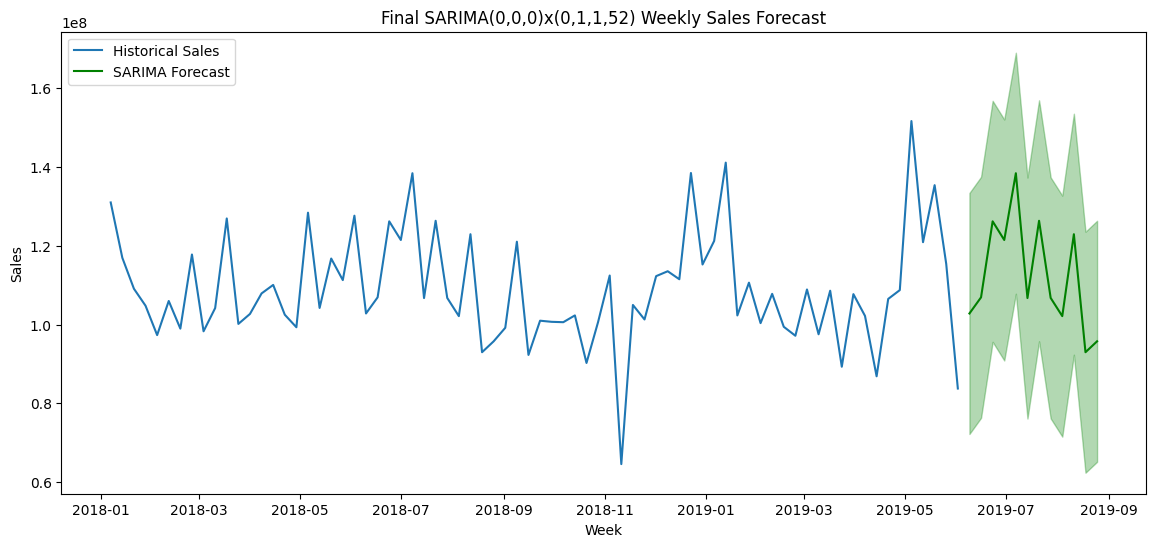

In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

best_sarima_model = SARIMAX(
    weekly_sales['Weekly_Sales'],
    order=(0, 0, 0),
    seasonal_order=(0, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
best_sarima_result = best_sarima_model.fit(disp=False)

sarima_forecast = best_sarima_result.get_forecast(steps=12)
conf_int = sarima_forecast.conf_int()
predicted_mean = sarima_forecast.predicted_mean

# Plot
plt.figure(figsize=(14,6))
plt.plot(weekly_sales.index, weekly_sales['Weekly_Sales'], label='Historical Sales')
plt.plot(predicted_mean.index, predicted_mean, label='SARIMA Forecast', color='green')
plt.fill_between(predicted_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.3)
plt.title("Final SARIMA(0,0,0)x(0,1,1,52) Weekly Sales Forecast")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.legend()
plt.show()


#### **Summary:**

* Seasonal trend clearly captured (weekly seasonality).
* Good AIC (4.0).
* forecast looks well-aligned with past seasonal trends and the confidence intervals are reasonable.
* No hyperparameter issues encountered with manual tuning.

### **Prophet**

#### **Prepare Data**

In [58]:
print(weekly_sales.head())
print(weekly_sales.columns)

            Weekly_Sales  Weekly_Sales_Diff
Date                                       
2018-01-07  1.310205e+08                NaN
2018-01-14  1.169641e+08       -14056418.13
2018-01-21  1.090989e+08        -7865237.37
2018-01-28  1.047842e+08        -4314702.90
2018-02-04  9.732072e+07        -7463469.21
Index(['Weekly_Sales', 'Weekly_Sales_Diff'], dtype='object')


In [59]:
# Reset index so 'Date' becomes a column
weekly_sales_reset = weekly_sales.reset_index()

# Rename for Prophet: 'Date' → 'ds', 'Weekly_Sales' → 'y'
prophet_df = weekly_sales_reset.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

# Ensure datetime type (important for Prophet)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Final check
prophet_df.head()

,ds,y,Weekly_Sales_Diff
0,2018-01-07,1.310205e+08,NaN
1,2018-01-14,1.169641e+08,-14056418.13
2,2018-01-21,1.090989e+08,-7865237.37
3,2018-01-28,1.047842e+08,-4314702.90
4,2018-02-04,9.732072e+07,-7463469.21


#### **Fit the prophet model**

In [64]:
from prophet import Prophet

prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxuhqvdk0/e2hoxwi0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxuhqvdk0/14ge3_wm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56063', 'data', 'file=/tmp/tmpxuhqvdk0/e2hoxwi0.json', 'init=/tmp/tmpxuhqvdk0/14ge3_wm.json', 'output', 'file=/tmp/tmpxuhqvdk0/prophet_model0m6wy6ts/prophet_model-20250816210200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:02:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### **Create Future Dates and Forecast**

In [65]:
# Forecast next 12 weeks
future = prophet_model.make_future_dataframe(periods=12, freq='W')
forecast = prophet_model.predict(future)

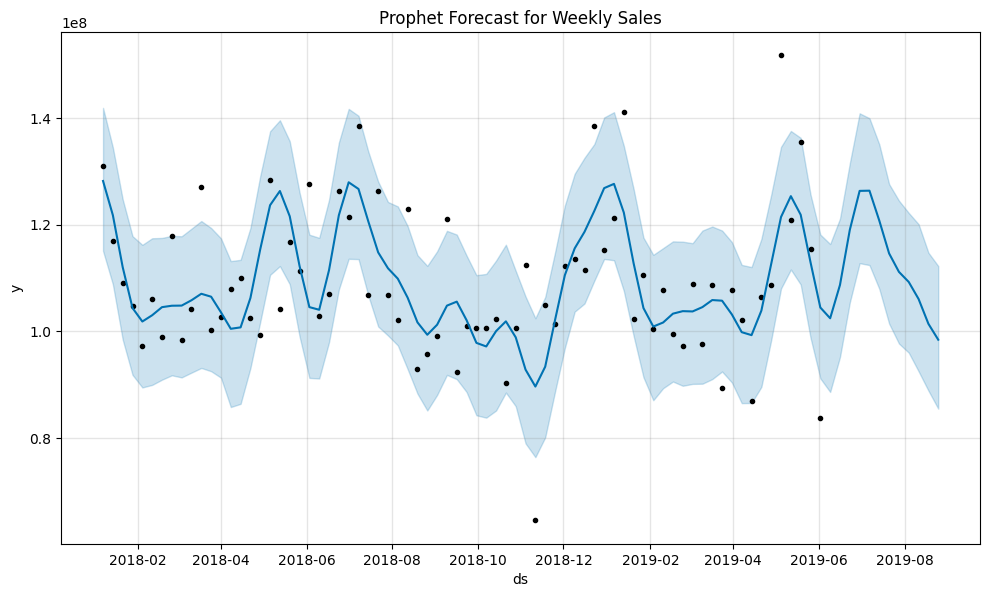

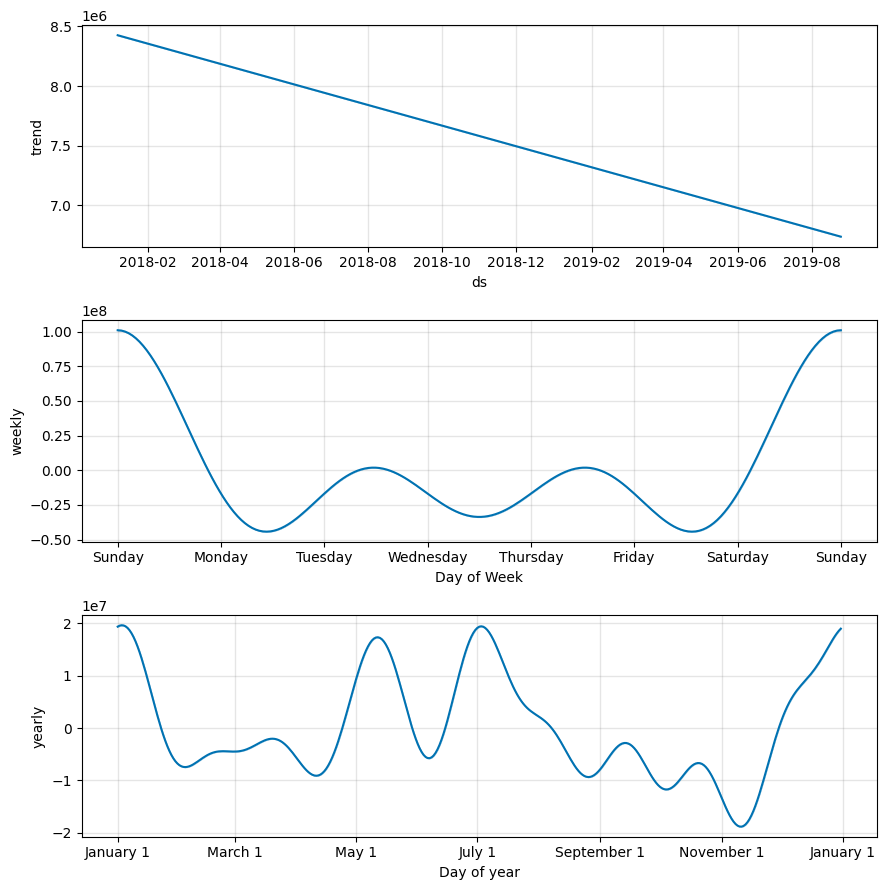

In [66]:
# Plot forecast
fig1 = prophet_model.plot(forecast)
plt.title('Prophet Forecast for Weekly Sales')
plt.show()

# Optional: component plots (trend, seasonality)
fig2 = prophet_model.plot_components(forecast)
plt.show()


#### **Visual Insights**

**ARIMA(1,1,1):**

* Flat forecast line.
* Confidence intervals widen over time, indicating growing uncertainty.
* Not suitable if seasonality exists (which clearly does in your case).

**SARIMA(0,0,0)(0,1,1,52):**

* Captures seasonal fluctuations reasonably well (weekly seasonality of 52).
* Forecast fluctuates to reflect past seasonal behavior.
* Confidence intervals still widen but the pattern is more consistent with real sales history.

**Prophet:**

* Strong seasonality decomposition:
* Trend component shows a slight declining pattern.
* Weekly seasonality: Highest sales on Sundays, lowest mid-week.
* Yearly seasonality: Peaks around Jan, May, July; dips near Nov.
* Forecast aligns closely with observed trends.
* Handles missing dates and irregular time series without preprocessing.

#### **✅ Recommendation – Best Model**

📌 Prophet is the best-suited model for your weekly sales forecasting due to:

* Its automated handling of trend, multiple seasonality levels, and holidays (can be added).
* Interpretability via component plots.
* No need to manually tune p,d,q seasonal orders.

**Alternative: Use SARIMA if:**

* If we prefer classical statistical models and have consistent weekly data with strong yearly cycles.
* We want full manual control over seasonality and differencing.

# **Save the best models**

In [67]:
import pickle

# Save the Prophet model
with open('../content/prophet_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)

print("Prophet model saved as prophet_model.pkl")


Prophet model saved as prophet_model.pkl


In [68]:
# Save the XGBoost model
with open('../content/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("XGBoost model saved as xgb_model.pkl")


XGBoost model saved as xgb_model.pkl
